In [6]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
images = glob.glob("./log/undistorted*.png")

def absolute_sobel_threshold(image, orient='x', sobel_kernel=3, threshold=(0, 255)):
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  binary_orient = (1, 0)
  if (orient == 'y'):
    binary_orient = (0, 1)
  sobel = cv2.Sobel(gray, cv2.CV_64F, *binary_orient, ksize=sobel_kernel)
  abs_sobel = np.absolute(sobel)
  scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
  binary_output = np.zeros_like(scaled_sobel)
  binary_output[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
  return binary_output


def magnitude_sobel_threshold(image, sobel_kernel=3, threshold=(0, 255)):
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
  sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
  mag = np.sqrt(np.power(sobel_x, 2) + np.power(sobel_y, 2))
  scaled_mag = np.uint8(255 * mag / np.max(mag))
  binary_output = np.zeros_like(scaled_mag)
  binary_output[(scaled_mag >= threshold[0]) & (scaled_mag <= threshold[1])] = 1
  return binary_output


def direction_sobel_threshold(image, sobel_kernel=3, threshold=(0, np.pi / 2)):
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
  sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
  abs_sobel_x = np.absolute(sobel_x)
  abs_sobel_y = np.absolute(sobel_y)
  direction = np.arctan2(abs_sobel_y, abs_sobel_x)
  binary_output = np.zeros_like(direction)
  binary_output[(direction >= threshold[0]) & (direction <= threshold[1])] = 1
  return binary_output

def saturation_threshold(image, threshold=(0, 255)):
  img_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
  S = img_hls[:, :, 2]
  binary_output = np.zeros_like(S)
  binary_output[(S > threshold[0]) & (S <= threshold[1])] = 1
  return binary_output

def white_and_yellow(image):
  hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

  white_image = np.ones((image.shape[0], image.shape[1], 1), np.uint8)
  yellow_mask = cv2.inRange(hsv, np.array([20,90,90]), np.array([30,255,255]))
  white_mask = cv2.inRange(hsv, np.array([0,0,200]), np.array([255,30,255]))

  w_image = cv2.bitwise_and(white_image, white_image, mask=white_mask)
  y_image = cv2.bitwise_and(white_image, white_image, mask=yellow_mask)

  result = cv2.bitwise_or(y_image, w_image)
  return result


def birds_eye_matrix_road(shape, inverse):
  width = shape[1]
  height = shape[0]

  sll = [width * 0.42, height * 0.65]
  slr = [width * 0.58, height * 0.65]
  sul = [width * 0.15, height * 0.98]
  sur = [width * 0.85, height * 0.98]

  dll = [width * 0.15, 0]
  dlr = [width * 0.85, 0]
  dul = [width * 0.15, height]
  dur = [width * 0.85, height]

  src = np.float32([sll, slr, sur, sul])
  dst = np.float32([dll, dlr, dur, dul])

  if inverse == True:
    M = cv2.getPerspectiveTransform(dst, src)
  else:
    M = cv2.getPerspectiveTransform(src, dst)
  return M


def adaptive_histogram(image):
  img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
  img_v = img_hsv[...,2]
  value_equalized = cv2.equalizeHist(img_v)
  img_hsv[...,2] = value_equalized
  result = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
  return result


def region_of_interest(img):
  """
  Applies an image mask.

  Only keeps the region of the image defined by the polygon
  formed from `vertices`. The rest of the image is set to black.
  """
  ysize = img.shape[0]
  xsize = img.shape[1]
  vertices = np.array([[(50, ysize),
                        (xsize - 50, ysize),
                        (xsize / 2 + 50, round(0.6 * ysize)),
                        (xsize / 2 - 50, round(0.6 * ysize)),
                        (50, ysize)]], dtype=np.int32)

  # defining a blank mask to start with
  mask = np.zeros_like(img)

  # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
  if len(img.shape) > 2:
    channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,) * channel_count
  else:
    ignore_mask_color = 255

  # filling pixels inside the polygon defined by "vertices" with the fill color
  cv2.fillPoly(mask, vertices, ignore_mask_color)

  # returning the image only where mask pixels are nonzero
  masked_image = cv2.bitwise_and(img, mask)
  return masked_image

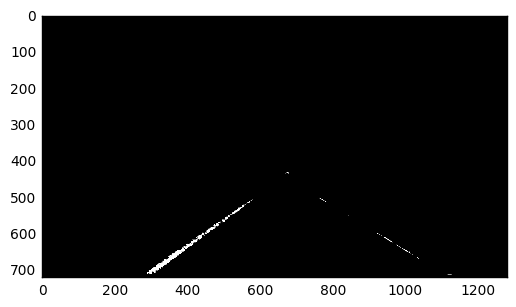

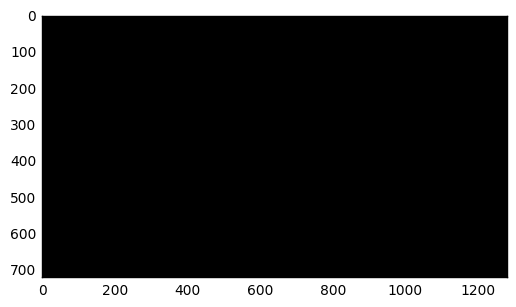

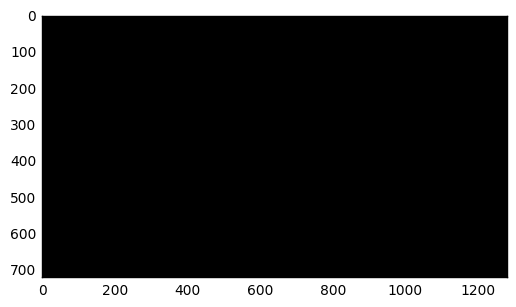

In [38]:
%matplotlib inline
from IPython.html.widgets import interact
from IPython.display import display
file = "./log/undistortedf0c0.png"
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
roi = region_of_interest(image_rgb)

def update(ksize, min_gradx, max_gradx, min_grady, max_grady, min_mag, max_mag, min_dir, max_dir, min_sat, max_sat):
    white_yellow_image = region_of_interest(white_and_yellow(image))
    sobel_x = region_of_interest(absolute_sobel_threshold(image, 'x', ksize, (min_gradx, max_gradx)))
    sobel_y = region_of_interest(absolute_sobel_threshold(image, 'y', ksize, (min_grady, max_grady)))
    sobel_magnitude = region_of_interest(magnitude_sobel_threshold(image, ksize, (min_mag, max_mag)))
    sobel_direction = region_of_interest(direction_sobel_threshold(image, ksize, (min_dir, max_dir)))
    saturation = region_of_interest(saturation_threshold(image, (min_sat, max_sat)))

    combined1 = np.zeros_like(sobel_magnitude)
    combined1[(white_yellow_image == 1) & ( (saturation==1) | (sobel_x==1) | (sobel_magnitude==1))] = 1
    combined2 = np.zeros_like(sobel_magnitude)
    combined3 = np.zeros_like(sobel_magnitude)

    plt.imshow(white_yellow_image, cmap='gray')
    plt.show()
    plt.imshow(sobel_x, cmap='gray')
    plt.show()
    plt.imshow(combined1, cmap='gray')

interact(update, ksize=(1,31,2), min_gradx=(0,255), max_gradx=(0,255), min_grady=(0,255), max_grady=(0,255), 
         min_mag=(0,255), max_mag=(0,255), min_dir=(0,np.pi/2), max_dir=(0,np.pi/2), 
         min_sat=(0,255), max_sat=(0,255));